# Question 2

Goal:- 
1. Implement Self-supervised learning using Momentum Con-trast Encoder method (MoCO). 
2. Try 3 Augmentations on the images
3. Im-plement a linear classifier on the learnt representations.
4. Compare it witha full-blown CNN
5. Record the reduction in the supervised data needed

# Part 1 : Pretraining

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm
import torch.nn.functional as F
import Models.Network as models
from torchsummary import summary
import random

In [ ]:
# Loading Dataset

dataroot = r"/data4/home/hrishikeshj/DLNLP/ADRLA2/Dataset/train"
image_size = 128
batch_size = 64

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)

In [ ]:
# Hyper parameters
dim_of_emb = 128
device_to_use = 1

In [ ]:
# Resnet Implementation taken from pytorch

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class projection_MLP(nn.Module):
    def __init__(self):
        super(projection_MLP, self).__init__()

        n_channels = 512

        self.projection_head = nn.Sequential()

        self.projection_head.add_module('W1', nn.Linear(
            n_channels, n_channels))
        self.projection_head.add_module('ReLU', nn.ReLU())
        self.projection_head.add_module('W2', nn.Linear(
            n_channels, 128))

    def forward(self, x):
        return self.projection_head(x)

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=128, zero_init_residual=False,
                 groups=1, width_per_group=64):
        super(ResNet, self).__init__()
        
        self._norm_layer = nn.BatchNorm2d

        self.register_buffer

        self.inplanes = 64
        self.dilation = 1
        
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                   bias=False)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            

        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion,num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                # if isinstance(m, Bottleneck):
                #     nn.init.constant_(m.bn3.weight, 0)
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x

In [ ]:
# Hyper parameters

queue_size = 128*batch_size
momentum = 0.999
temperature = 0.07

learning_rate = 0.03
sgd_weight_decay = 0.0001
sgd_momentum = 0.9
num_epochs = 100

In [ ]:
class MoCo_Model(nn.Module):
    def __init__(self):
        
        super(MoCo_Model, self).__init__()

        self.queue_size = queue_size
        self.momentum = momentum
        self.temperature = temperature

        assert self.queue_size % batch_size == 0  # for simplicity

        # Load model
        self.query_encoder = ResNet(BasicBlock,[2,2,2,2],num_classes=dim_of_emb)
        self.key_encoder = ResNet(BasicBlock,[2,2,2,2],num_classes=dim_of_emb)

        self.query_encoder.fc = projection_MLP()
        self.key_encoder.fc = projection_MLP()


        # Initialize the key encoder to have the same values as query encoder
        # Do not update the key encoder via gradient
        for query_param, key_param in zip(self.query_encoder.parameters(), self.key_encoder.parameters()):
            key_param.data.copy_(query_param.data)
            key_param.requires_grad = False

        # Create the queue to store negative samples
        self.register_buffer("queue", torch.randn(self.queue_size, dim_of_emb))

        # Create pointer to store current position in the queue when enqueue and dequeue
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def momentum_update(self):
        
        # For each of the parameters in each encoder
        for p_q, p_k in zip(self.query_encoder.parameters(), self.key_encoder.parameters()):
            p_k.data = p_k.data * self.momentum + p_q.detach().data * (1. - self.momentum)

    @torch.no_grad()
    def shuffled_idx(self, batch_size):

        # Generate shuffled indexes
        shuffled_idxs = torch.randperm(batch_size).long().cuda()

        reverse_idxs = torch.zeros(batch_size).long().cuda()

        value = torch.arange(batch_size).long().cuda()

        reverse_idxs.index_copy_(0, shuffled_idxs, value)

        return shuffled_idxs, reverse_idxs

    @torch.no_grad()
    def update_queue(self, feat_k):

        curr_BS = feat_k.size(0)

        ptr = int(self.queue_ptr)

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[ptr:ptr + curr_BS, :] = feat_k

        # move pointer along to end of current batch
        ptr = (ptr + curr_BS) % self.queue_size

        # Store queue pointer as register_buffer
        self.queue_ptr[0] = ptr

    def InfoNCE_logits(self, f_q, f_k):

        f_k = f_k.detach()

        # Get queue from register_buffer
        f_mem = self.queue.clone().detach()

        # Normalize the feature representations
        f_q = nn.functional.normalize(f_q, dim=1)
        f_k = nn.functional.normalize(f_k, dim=1)
        f_mem = nn.functional.normalize(f_mem, dim=1)

        # Compute sim between positive views
        pos = torch.bmm(f_q.view(f_q.size(0), 1, -1),
                        f_k.view(f_k.size(0), -1, 1)).squeeze(-1)

        # Compute sim between postive and all negatives in the memory
        neg = torch.mm(f_q, f_mem.transpose(1, 0))

        logits = torch.cat((pos, neg), dim=1)

        logits /= self.temperature

        # Create labels, first logit is postive, all others are negative
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        return logits, labels

    def forward(self, x_q, x_k):

        batch_size = x_q.size(0)

        # Feature representations of the query view from the query encoder
        feat_q = self.query_encoder(x_q)

        # TODO: shuffle ids with distributed data parallel
        # Get shuffled and reversed indexes for the current minibatch
        shuffled_idxs, reverse_idxs = self.shuffled_idx(batch_size)

        with torch.no_grad():
            # Update the key encoder
            self.momentum_update()

            # Shuffle minibatch
            x_k = x_k[shuffled_idxs]

            # Feature representations of the shuffled key view from the key encoder
            feat_k = self.key_encoder(x_k)

            # reverse the shuffled samples to original position
            feat_k = feat_k[reverse_idxs]

        # Compute the logits for the InfoNCE contrastive loss.
        logit, label = self.InfoNCE_logits(feat_q, feat_k)

        # Update the queue/memory with the current key_encoder minibatch.
        self.update_queue(feat_k)

        return logit, label

In [ ]:
mocoModel = MoCo_Model()

torch.cuda.set_device(device_to_use)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

mocoModel = mocoModel.to(device=device)

In [ ]:
optimiser = torch.optim.SGD(mocoModel.parameters(), lr=learning_rate, weight_decay=sgd_weight_decay, momentum=sgd_momentum)
lr_decay = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, num_epochs)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
augmentation = [
            transforms.RandomGrayscale(p=0.2),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]

augTransform = transforms.Compose(augmentation)

In [ ]:
#Pretraining 
number_of_steps = len(dataloader)*num_epochs
progress_bar = tqdm(range(number_of_steps))

mocoModel.train()
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(dataloader):
        optimiser.zero_grad()
        #images : [bs,3,128,128]
        images = images.to(device)
        #Get two augmentations:
        query_images = augTransform(images)
        key_images = augTransform(images)

        all_logits, labels = mocoModel(query_images,key_images)
        #all_logits : [(queue_size + 1),emb_dim]
        #labels : [(queue_size + 1)], Tensor of all zeros

        loss = criterion(all_logits,labels)

        loss.backward()

        optimiser.step()

        progress_bar.update()

        if i%500 == 0:
            print("Pretrain_loss : ",loss.item())

    lr_decay.step()


  0%|          | 3/22800 [00:33<54:33:09,  8.61s/it] 

Pretrain_loss :  0.02857186272740364


  1%|          | 230/22800 [02:23<2:03:29,  3.05it/s]

Pretrain_loss :  5.432933807373047


  2%|▏         | 456/22800 [02:42<29:20, 12.69it/s]  

Pretrain_loss :  4.812164306640625


  3%|▎         | 688/22800 [03:28<2:04:57,  2.95it/s]

Pretrain_loss :  3.1110713481903076


  4%|▍         | 916/22800 [04:13<1:27:14,  4.18it/s]

Pretrain_loss :  2.9676005840301514


  5%|▌         | 1143/22800 [04:24<45:57,  7.85it/s] 

Pretrain_loss :  2.0683467388153076


  6%|▌         | 1373/22800 [04:38<1:11:56,  4.96it/s]

Pretrain_loss :  1.715352177619934


  7%|▋         | 1601/22800 [04:53<36:35,  9.66it/s]  

Pretrain_loss :  1.6454323530197144


  8%|▊         | 1825/22800 [05:38<2:04:50,  2.80it/s]

Pretrain_loss :  1.3108285665512085


  9%|▉         | 2053/22800 [06:21<2:16:53,  2.53it/s]

Pretrain_loss :  1.1967517137527466


 10%|█         | 2284/22800 [07:08<1:28:18,  3.87it/s]

Pretrain_loss :  1.2320719957351685


 11%|█         | 2511/22800 [07:51<1:03:24,  5.33it/s]

Pretrain_loss :  0.9905940890312195


 12%|█▏        | 2742/22800 [08:03<34:35,  9.66it/s]  

Pretrain_loss :  1.044512391090393


 13%|█▎        | 2968/22800 [08:16<44:31,  7.42it/s]

Pretrain_loss :  1.212280511856079


 14%|█▍        | 3195/22800 [09:00<1:58:22,  2.76it/s]

Pretrain_loss :  0.9807380437850952


 15%|█▌        | 3423/22800 [09:44<1:26:57,  3.71it/s]

Pretrain_loss :  0.6864845156669617


 16%|█▌        | 3649/22800 [10:04<1:06:00,  4.84it/s]

Pretrain_loss :  0.7475559711456299


 17%|█▋        | 3880/22800 [10:53<1:49:37,  2.88it/s]

Pretrain_loss :  0.7188102602958679


 18%|█▊        | 4109/22800 [11:36<1:05:31,  4.75it/s]

Pretrain_loss :  0.6822733283042908


 19%|█▉        | 4337/22800 [11:48<34:12,  9.00it/s]  

Pretrain_loss :  0.6863484382629395


 20%|██        | 4565/22800 [12:00<38:00,  8.00it/s]

Pretrain_loss :  0.5740864276885986


 21%|██        | 4791/22800 [12:12<39:08,  7.67it/s]

Pretrain_loss :  0.5262278914451599


 22%|██▏       | 5017/22800 [12:23<38:02,  7.79it/s]

Pretrain_loss :  0.5228994488716125


 23%|██▎       | 5247/22800 [13:06<2:24:42,  2.02it/s]

Pretrain_loss :  0.8031159043312073


 24%|██▍       | 5475/22800 [13:48<1:23:33,  3.46it/s]

Pretrain_loss :  0.5473595857620239


 25%|██▌       | 5703/22800 [14:28<1:16:52,  3.71it/s]

Pretrain_loss :  0.5799432992935181


 26%|██▌       | 5932/22800 [14:44<59:14,  4.75it/s]  

Pretrain_loss :  0.5977439284324646


 27%|██▋       | 6161/22800 [15:27<1:00:23,  4.59it/s]

Pretrain_loss :  0.4535023272037506


 28%|██▊       | 6387/22800 [15:58<1:11:02,  3.85it/s]

Pretrain_loss :  0.6267112493515015


 29%|██▉       | 6615/22800 [16:18<50:07,  5.38it/s]  

Pretrain_loss :  0.3857680857181549


 30%|███       | 6842/22800 [16:38<52:49,  5.04it/s]

Pretrain_loss :  0.43619000911712646


 31%|███       | 7070/22800 [16:57<51:28,  5.09it/s]

Pretrain_loss :  0.45538416504859924


 32%|███▏      | 7299/22800 [17:15<28:24,  9.10it/s]

Pretrain_loss :  0.4143941104412079


 33%|███▎      | 7526/22800 [17:29<1:11:23,  3.57it/s]

Pretrain_loss :  0.3596288561820984


 34%|███▍      | 7753/22800 [18:13<1:31:06,  2.75it/s]

Pretrain_loss :  0.5080121755599976


 35%|███▌      | 7985/22800 [18:48<31:51,  7.75it/s]  

Pretrain_loss :  0.3400283455848694


 36%|███▌      | 8214/22800 [19:00<25:58,  9.36it/s]

Pretrain_loss :  0.4514525830745697


 37%|███▋      | 8439/22800 [19:11<33:14,  7.20it/s]

Pretrain_loss :  0.42034757137298584


 38%|███▊      | 8667/22800 [19:23<34:01,  6.92it/s]

Pretrain_loss :  0.45257025957107544


 39%|███▉      | 8894/22800 [19:37<48:38,  4.76it/s]

Pretrain_loss :  0.37456637620925903


 40%|████      | 9123/22800 [20:25<2:03:45,  1.84it/s]

Pretrain_loss :  0.34982964396476746


 41%|████      | 9352/22800 [21:06<57:28,  3.90it/s]  

Pretrain_loss :  0.33774200081825256


 42%|████▏     | 9578/22800 [21:42<1:13:27,  3.00it/s]

Pretrain_loss :  0.2659962773323059


 43%|████▎     | 9807/22800 [21:58<59:56,  3.61it/s]  

Pretrain_loss :  0.30895504355430603


 44%|████▍     | 10033/22800 [22:39<58:38,  3.63it/s]

Pretrain_loss :  0.27158981561660767


 45%|████▌     | 10263/22800 [23:27<1:49:31,  1.91it/s]

Pretrain_loss :  0.38778960704803467


 46%|████▌     | 10493/22800 [23:45<24:10,  8.48it/s]  

Pretrain_loss :  0.35142460465431213


 47%|████▋     | 10721/22800 [23:57<22:24,  8.99it/s]

Pretrain_loss :  0.3041897416114807


 48%|████▊     | 10946/22800 [24:08<23:49,  8.29it/s]

Pretrain_loss :  0.2734185755252838


 49%|████▉     | 11179/22800 [24:22<29:40,  6.53it/s]

Pretrain_loss :  0.2829796075820923


 50%|█████     | 11402/22800 [25:06<57:53,  3.28it/s]

Pretrain_loss :  0.30676722526550293


 51%|█████     | 11632/22800 [25:18<19:57,  9.33it/s]

Pretrain_loss :  0.34706705808639526


 52%|█████▏    | 11862/22800 [25:30<26:44,  6.82it/s]

Pretrain_loss :  0.264839768409729


 53%|█████▎    | 12089/22800 [25:43<37:26,  4.77it/s]

Pretrain_loss :  0.30805954337120056


 54%|█████▍    | 12315/22800 [26:28<44:19,  3.94it/s]

Pretrain_loss :  0.3121994435787201


 55%|█████▌    | 12542/22800 [26:47<29:43,  5.75it/s]

Pretrain_loss :  0.2698330283164978


 56%|█████▌    | 12769/22800 [27:30<51:44,  3.23it/s]

Pretrain_loss :  0.3213063180446625


 57%|█████▋    | 13002/22800 [27:42<17:26,  9.37it/s]

Pretrain_loss :  0.21232540905475616


 58%|█████▊    | 13228/22800 [27:54<17:25,  9.16it/s]

Pretrain_loss :  0.35268789529800415


 59%|█████▉    | 13455/22800 [28:06<17:44,  8.78it/s]

Pretrain_loss :  0.45303910970687866


 60%|██████    | 13683/22800 [28:17<16:23,  9.27it/s]

Pretrain_loss :  0.26786649227142334


 61%|██████    | 13911/22800 [28:30<19:10,  7.73it/s]

Pretrain_loss :  0.28472304344177246


 62%|██████▏   | 14140/22800 [28:44<31:57,  4.52it/s]

Pretrain_loss :  0.31563007831573486


 63%|██████▎   | 14366/22800 [29:30<45:08,  3.11it/s]

Pretrain_loss :  0.2795591950416565


 64%|██████▍   | 14594/22800 [29:52<54:05,  2.53it/s]  

Pretrain_loss :  0.24306200444698334


 65%|██████▌   | 14822/22800 [30:38<37:53,  3.51it/s]

Pretrain_loss :  0.19499675929546356


 66%|██████▌   | 15048/22800 [30:49<04:53, 26.38it/s]

Pretrain_loss :  0.3647770881652832


 67%|██████▋   | 15280/22800 [31:33<30:34,  4.10it/s]

Pretrain_loss :  0.2503824532032013


 68%|██████▊   | 15507/22800 [32:16<33:44,  3.60it/s]

Pretrain_loss :  0.2896762192249298


 69%|██████▉   | 15735/22800 [32:29<16:43,  7.04it/s]

Pretrain_loss :  0.3267640173435211


 70%|███████   | 15962/22800 [32:42<14:59,  7.60it/s]

Pretrain_loss :  0.3271937668323517


 71%|███████   | 16191/22800 [33:02<38:30,  2.86it/s]

Pretrain_loss :  0.2367960512638092


 72%|███████▏  | 16419/22800 [33:47<24:52,  4.27it/s]

Pretrain_loss :  0.20355947315692902


 73%|███████▎  | 16646/22800 [34:27<33:26,  3.07it/s]

Pretrain_loss :  0.2637384235858917


 74%|███████▍  | 16875/22800 [35:10<29:46,  3.32it/s]

Pretrain_loss :  0.24255460500717163


 75%|███████▌  | 17102/22800 [35:55<25:26,  3.73it/s]

Pretrain_loss :  0.2367638796567917


 76%|███████▌  | 17330/22800 [36:31<25:53,  3.52it/s]

Pretrain_loss :  0.27130815386772156


 77%|███████▋  | 17558/22800 [37:16<42:02,  2.08it/s]

Pretrain_loss :  0.2813325822353363


 78%|███████▊  | 17787/22800 [38:01<28:34,  2.92it/s]

Pretrain_loss :  0.24158549308776855


 79%|███████▉  | 18012/22800 [38:13<03:43, 21.41it/s]

Pretrain_loss :  0.26637107133865356


 80%|████████  | 18243/22800 [38:35<21:01,  3.61it/s]

Pretrain_loss :  0.27872592210769653


 81%|████████  | 18471/22800 [39:17<16:40,  4.32it/s]

Pretrain_loss :  0.33952081203460693


 82%|████████▏ | 18697/22800 [39:30<08:38,  7.92it/s]

Pretrain_loss :  0.33644068241119385


 83%|████████▎ | 18927/22800 [40:12<20:09,  3.20it/s]

Pretrain_loss :  0.2937498986721039


 84%|████████▍ | 19156/22800 [40:57<13:52,  4.38it/s]

Pretrain_loss :  0.22684931755065918


 85%|████████▌ | 19383/22800 [41:11<16:16,  3.50it/s]

Pretrain_loss :  0.24903248250484467


 86%|████████▌ | 19610/22800 [41:54<13:10,  4.03it/s]

Pretrain_loss :  0.31990760564804077


 87%|████████▋ | 19836/22800 [42:38<07:10,  6.88it/s]

Pretrain_loss :  0.2068905383348465


 88%|████████▊ | 20067/22800 [43:25<12:11,  3.74it/s]

Pretrain_loss :  0.23989754915237427


 89%|████████▉ | 20295/22800 [43:45<06:04,  6.87it/s]

Pretrain_loss :  0.3143938183784485


 90%|█████████ | 20523/22800 [43:57<05:12,  7.28it/s]

Pretrain_loss :  0.2616685628890991


 91%|█████████ | 20752/22800 [44:09<03:06, 10.98it/s]

Pretrain_loss :  0.223558709025383


 92%|█████████▏| 20982/22800 [44:20<03:14,  9.33it/s]

Pretrain_loss :  0.18972350656986237


 93%|█████████▎| 21205/22800 [44:32<03:17,  8.08it/s]

Pretrain_loss :  0.17588089406490326


 94%|█████████▍| 21437/22800 [45:16<05:58,  3.81it/s]

Pretrain_loss :  0.2660849094390869


 95%|█████████▌| 21664/22800 [46:00<03:53,  4.86it/s]

Pretrain_loss :  0.23346643149852753


 96%|█████████▌| 21890/22800 [46:19<04:29,  3.37it/s]

Pretrain_loss :  0.33552953600883484


 97%|█████████▋| 22119/22800 [46:42<03:31,  3.22it/s]

Pretrain_loss :  0.34154796600341797


 98%|█████████▊| 22347/22800 [47:27<02:12,  3.42it/s]

Pretrain_loss :  0.27680158615112305


 99%|█████████▉| 22577/22800 [48:14<01:11,  3.13it/s]

Pretrain_loss :  0.211419016122818


100%|█████████▉| 22799/22800 [48:56<00:00,  5.73it/s]

100%|██████████| 22800/22800 [49:10<00:00,  5.73it/s]

In [ ]:
# Saing Pretrained Moco Model
ModelPath = "/data4/home/hrishikeshj/DLNLP/ADRLA3/trainedModels/TR1/mocoModel.pt"
torch.save(mocoModel.state_dict(),ModelPath)

# Part 2 : Fine-Tuning

In [ ]:
# We create the CNN model we had used for pretraining. it already has a fully connected layer, which will be fine
# tuned. 

query_encoder = ResNet(BasicBlock,[2,2,2,2],num_classes=3)

In [ ]:
# Loading pre-trained MoCo Model

modelPath = "/data4/home/hrishikeshj/DLNLP/ADRLA3/trainedModels/TR1/mocoModel.pt"
moco_state_dict = torch.load(modelPath)
for k in list(moco_state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('query_encoder.') and not k.startswith('query_encoder.fc'):
        # remove prefix
        moco_state_dict[k[len("query_encoder."):]] = moco_state_dict[k]
    # delete renamed or unused k
    del moco_state_dict[k]


query_encoder.load_state_dict(moco_state_dict,strict=False)

torch.cuda.set_device(device_to_use)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

query_encoder = query_encoder.to(device)

In [ ]:
# Creates a subsampler that samples x% of data from the train dataset

class_wise_indices = {0:[i for i in range(5153)],1:[i for i in range(5153,9892)],2:[i for i in range(9892,14629)]}

percentage = 0.9

subset_indices = []

for label in range(3):
    num_of_samples = len(class_wise_indices[label])
    num_of_samples = round(percentage*num_of_samples)
    subset_indices.extend(class_wise_indices[label][:num_of_samples])

print("After sampling : ",len(subset_indices))
random.shuffle(subset_indices)
subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)

subset_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size
                                         , num_workers=8, drop_last=True,sampler=subset_sampler)

After sampling :  13166


In [ ]:
# Hyperparameters for Fine-tuning

batch_size = 32
learning_rate = 0.001
fine_tune_epochs = 200
patience = 40 # For Early stopping

In [ ]:
optimiser = torch.optim.Adam(query_encoder.parameters(), lr=learning_rate)
lr_decay = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, num_epochs)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
# Evaluation on test dataset
def evaluate(encoder, test_dataloader):
    valid_loss = 0.0  # reset loss
    valid_acc = 0.0  # reset acc
    
    criterion = nn.CrossEntropyLoss().cuda()

    # Evaluate both encoder and class head
    encoder.eval()

    for i, (inputs, target) in enumerate(test_dataloader):

        # Do not compute gradient for encoder and classification head
        encoder.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)
        # Forward pass

        output = encoder(inputs)

        loss = criterion(output, target)

        valid_loss += loss.item()

        predicted = output.argmax(-1)

        acc = (predicted == target).sum().item() / target.size(0)

        valid_acc += acc

    valid_loss = valid_loss / len(test_dataloader)

    valid_acc = valid_acc / len(test_dataloader)

    print("Test loss : ",valid_loss)
    print("Test Acc : ",valid_acc)
    return valid_loss, valid_acc

In [ ]:
# Training Loop

model_storage_path = "/data4/home/hrishikeshj/DLNLP/ADRLA3/FineTunedModels/FT10Perc.pt"
progress_bar = tqdm(range(fine_tune_epochs*len(subset_dataloader)))
best_test_acc = 0.0
best_epoch = 0
patience_counter = 0
for epoch in range(fine_tune_epochs):

    # Freeze the encoder, train classification head
    query_encoder.eval()
    run_loss = 0.0
    run_acc = 0.0

    

    for i, (inputs, target) in enumerate(subset_dataloader):

        inputs = inputs.to(device)
        target = target.to(device)

        # Forward pass
        optimiser.zero_grad()

        # Do not compute the gradients for the frozen encoder
        output = query_encoder(inputs)

        # Take pretrained encoder representations
        loss = criterion(output, target)

        loss.backward()

        optimiser.step()

        run_loss += loss.item()

        predicted = output.argmax(1)

        acc = (predicted == target).sum().item() / target.size(0)

        run_acc += acc

        progress_bar.update(1)

    epoch_finetune_loss = run_loss / len(subset_dataloader)  # sample_count

    epoch_finetune_acc = run_acc / len(subset_dataloader)

    ''' Update Schedulers '''
    # Decay lr with CosineAnnealingLR
    lr_decay.step()

    ''' Printing '''
    print("Epoch loss : ",epoch_finetune_loss)
    print("Epoch accuracy : ",epoch_finetune_acc)

    test_valid_loss, test_valid_acc = evaluate(query_encoder, test_dataloader)

    if test_valid_acc>best_test_acc:
        patience_counter = 0
        best_test_acc = test_valid_acc
        best_epoch = epoch + 1
        torch.save(query_encoder.state_dict(),model_storage_path)
    else:
        patience_counter += 1
        if patience_counter>=patience:
            print("Stopping early as no improvement since 20 epochs")
            break
        else:
            print("Patience Counter : ",patience_counter)

    
    epoch_finetune_loss = None  # reset loss
    epoch_finetune_acc = None

    torch.cuda.empty_cache()

print("Best Epoch : ",best_epoch)
print("Best test Accuracy : ",best_test_acc)


  0%|          | 0/82200 [00:00<?, ?it/s]

  0%|          | 411/82200 [00:49<2:08:19, 10.62it/s]

Epoch loss :  1.0139951437639203
Epoch accuracy :  0.4565845498783455
Test loss :  0.8604963046053181
Test Acc :  0.6127717391304348


  1%|          | 821/82200 [01:33<2:10:17, 10.41it/s] 

Epoch loss :  0.4278062965965619
Epoch accuracy :  0.8299878345498783
Test loss :  0.3221277111898298
Test Acc :  0.8838315217391305


  1%|▏         | 1232/82200 [01:53<38:37, 34.94it/s]  

Epoch loss :  0.234400772038675
Epoch accuracy :  0.9128649635036497
Test loss :  0.20364671921276528
Test Acc :  0.921875


  2%|▏         | 1641/82200 [02:08<38:49, 34.58it/s]  

Epoch loss :  0.1635260510682117
Epoch accuracy :  0.9371958637469586
Test loss :  0.12285667912953574
Test Acc :  0.954483695652174


  2%|▏         | 2054/82200 [02:23<35:28, 37.65it/s]  

Epoch loss :  0.1222479132892351
Epoch accuracy :  0.9559762773722628
Test loss :  0.18831975887651028
Test Acc :  0.938858695652174
Patience Counter :  1


  3%|▎         | 2466/82200 [02:39<38:39, 34.38it/s]  

Epoch loss :  0.09351277430122605
Epoch accuracy :  0.9648722627737226
Test loss :  0.11687575829336824
Test Acc :  0.9490489130434783
Patience Counter :  2


  3%|▎         | 2875/82200 [02:53<35:57, 36.76it/s]  

Epoch loss :  0.0660736741976237
Epoch accuracy :  0.975669099756691
Test loss :  0.13382008297206915
Test Acc :  0.9578804347826086


  4%|▍         | 3287/82200 [03:09<39:23, 33.39it/s]  

Epoch loss :  0.05456800083456297
Epoch accuracy :  0.9815237226277372
Test loss :  0.1460154240535896
Test Acc :  0.9490489130434783
Patience Counter :  1


  4%|▍         | 3697/82200 [03:50<2:03:04, 10.63it/s] 

Epoch loss :  0.04797698883297275
Epoch accuracy :  0.9825121654501217
Test loss :  0.13566044299446017
Test Acc :  0.9612771739130435


  5%|▍         | 4108/82200 [04:06<39:26, 33.00it/s]  

Epoch loss :  0.03949951517158215
Epoch accuracy :  0.9872262773722628
Test loss :  0.13234368347279404
Test Acc :  0.9599184782608695
Patience Counter :  1


  5%|▌         | 4520/82200 [04:21<39:29, 32.78it/s]  

Epoch loss :  0.03710954792028474
Epoch accuracy :  0.9876064476885644
Test loss :  0.157919452910352
Test Acc :  0.9605978260869565
Patience Counter :  2


  6%|▌         | 4932/82200 [04:36<38:41, 33.28it/s]  

Epoch loss :  0.03718560585189252
Epoch accuracy :  0.9872262773722628
Test loss :  0.1566937914695186
Test Acc :  0.9558423913043478
Patience Counter :  3


  6%|▋         | 5340/82200 [04:51<38:45, 33.06it/s]  

Epoch loss :  0.03169350434355292
Epoch accuracy :  0.9892031630170316
Test loss :  0.19485497413931982
Test Acc :  0.9463315217391305
Patience Counter :  4


  7%|▋         | 5752/82200 [05:06<39:21, 32.38it/s]  

Epoch loss :  0.027196423820387082
Epoch accuracy :  0.9911800486618005
Test loss :  0.163571265895608
Test Acc :  0.9578804347826086
Patience Counter :  5


  8%|▊         | 6165/82200 [05:21<38:04, 33.29it/s]  

Epoch loss :  0.017202583927003478
Epoch accuracy :  0.9931569343065694
Test loss :  0.1546669983502437
Test Acc :  0.9626358695652174


  8%|▊         | 6573/82200 [05:37<38:08, 33.04it/s]  

Epoch loss :  0.02490166962788442
Epoch accuracy :  0.9917883211678832
Test loss :  0.1400542892161352
Test Acc :  0.9578804347826086
Patience Counter :  1


  8%|▊         | 6985/82200 [05:52<37:23, 33.52it/s]  

Epoch loss :  0.027364422029849976
Epoch accuracy :  0.9909519464720195
Test loss :  0.10629939431901617
Test Acc :  0.9667119565217391


  9%|▉         | 7397/82200 [06:08<38:11, 32.64it/s]  

Epoch loss :  0.014252932316631866
Epoch accuracy :  0.996198296836983
Test loss :  0.13865772029305884
Test Acc :  0.9626358695652174
Patience Counter :  1


 10%|▉         | 7809/82200 [06:23<37:45, 32.84it/s]  

Epoch loss :  0.019737686066524925
Epoch accuracy :  0.9936131386861314
Test loss :  0.1741136110724809
Test Acc :  0.9592391304347826
Patience Counter :  2


 10%|▉         | 8217/82200 [06:38<37:29, 32.89it/s]  

Epoch loss :  0.01593430452566997
Epoch accuracy :  0.9949817518248175
Test loss :  0.15480635348143076
Test Acc :  0.9605978260869565
Patience Counter :  3


 10%|█         | 8629/82200 [06:53<37:42, 32.52it/s]  

Epoch loss :  0.01925231290162989
Epoch accuracy :  0.9941453771289538
Test loss :  0.17996192770869643
Test Acc :  0.9660326086956522
Patience Counter :  4


 11%|█         | 9041/82200 [07:08<36:02, 33.83it/s]  

Epoch loss :  0.01876533581586375
Epoch accuracy :  0.9946776155717761
Test loss :  0.12521348449492664
Test Acc :  0.9667119565217391
Patience Counter :  5


 12%|█▏        | 9453/82200 [07:23<35:59, 33.69it/s]  

Epoch loss :  0.011816269863183784
Epoch accuracy :  0.9960462287104623
Test loss :  0.16991961332646693
Test Acc :  0.9605978260869565
Patience Counter :  6


 12%|█▏        | 9861/82200 [07:38<35:27, 34.00it/s]  

Epoch loss :  0.01815996417148168
Epoch accuracy :  0.9931569343065694
Test loss :  0.19415907095168697
Test Acc :  0.9497282608695652
Patience Counter :  7


 12%|█▏        | 10273/82200 [07:53<36:43, 32.64it/s] 

Epoch loss :  0.010375064005729915
Epoch accuracy :  0.9967305352798054
Test loss :  0.1879168230163348
Test Acc :  0.9660326086956522
Patience Counter :  8


 13%|█▎        | 10685/82200 [08:08<36:12, 32.92it/s]  

Epoch loss :  0.015062670855478577
Epoch accuracy :  0.9950577858880778
Test loss :  0.18452275995387818
Test Acc :  0.954483695652174
Patience Counter :  9


 14%|█▎        | 11097/82200 [08:24<34:50, 34.01it/s]  

Epoch loss :  0.01742596948655348
Epoch accuracy :  0.9948296836982968
Test loss :  0.17271874061676182
Test Acc :  0.9653532608695652
Patience Counter :  10


 14%|█▍        | 11505/82200 [08:39<35:13, 33.45it/s]  

Epoch loss :  0.011402511242269767
Epoch accuracy :  0.9968826034063261
Test loss :  0.19467695061836782
Test Acc :  0.9619565217391305
Patience Counter :  11


 14%|█▍        | 11917/82200 [08:54<34:34, 33.87it/s]  

Epoch loss :  0.012295222086455884
Epoch accuracy :  0.9971867396593674
Test loss :  0.12659487227796015
Test Acc :  0.96875


 15%|█▍        | 12329/82200 [09:10<35:45, 32.56it/s]  

Epoch loss :  0.009880139606884551
Epoch accuracy :  0.996426399026764
Test loss :  0.15499934283434413
Test Acc :  0.9626358695652174
Patience Counter :  1


 16%|█▌        | 12741/82200 [09:25<34:29, 33.57it/s]  

Epoch loss :  0.009617575090314141
Epoch accuracy :  0.9968065693430657
Test loss :  0.1649003032202927
Test Acc :  0.9646739130434783
Patience Counter :  2


 16%|█▌        | 13151/82200 [09:40<35:14, 32.65it/s]  

Epoch loss :  0.013311217406777133
Epoch accuracy :  0.9958181265206812
Test loss :  0.17068799525630943
Test Acc :  0.9653532608695652
Patience Counter :  3


 16%|█▋        | 13562/82200 [09:55<34:51, 32.82it/s]  

Epoch loss :  0.009592804196999656
Epoch accuracy :  0.997110705596107
Test loss :  0.17208374796799666
Test Acc :  0.9605978260869565
Patience Counter :  4


 17%|█▋        | 13974/82200 [10:10<34:10, 33.27it/s]  

Epoch loss :  0.01132755026194751
Epoch accuracy :  0.9970346715328468
Test loss :  0.14449829227795935
Test Acc :  0.9633152173913043
Patience Counter :  5


 17%|█▋        | 14383/82200 [10:26<32:01, 35.30it/s]  

Epoch loss :  0.006508984344876418
Epoch accuracy :  0.9982512165450121
Test loss :  0.1392354055500144
Test Acc :  0.9592391304347826
Patience Counter :  6


 18%|█▊        | 14794/82200 [10:41<33:24, 33.63it/s]  

Epoch loss :  0.0053277310929947955
Epoch accuracy :  0.9980991484184915
Test loss :  0.20737611281196391
Test Acc :  0.970108695652174


 18%|█▊        | 15206/82200 [10:56<34:17, 32.55it/s]  

Epoch loss :  0.006568783092156104
Epoch accuracy :  0.9990875912408759
Test loss :  0.22950709022014684
Test Acc :  0.9605978260869565
Patience Counter :  1


 19%|█▉        | 15618/82200 [11:11<32:40, 33.96it/s]  

Epoch loss :  0.003242777441882393
Epoch accuracy :  0.9990115571776156
Test loss :  0.19828212921160943
Test Acc :  0.9714673913043478


 19%|█▉        | 16026/82200 [11:27<33:37, 32.80it/s]  

Epoch loss :  0.011545030397217642
Epoch accuracy :  0.9972627737226277
Test loss :  0.18502758167695624
Test Acc :  0.9619565217391305
Patience Counter :  1


 20%|█▉        | 16438/82200 [11:42<32:31, 33.71it/s]  

Epoch loss :  0.007634669630451671
Epoch accuracy :  0.9976429440389294
Test loss :  0.1594187671907212
Test Acc :  0.967391304347826
Patience Counter :  2


 20%|██        | 16850/82200 [11:57<33:29, 32.53it/s]  

Epoch loss :  0.008617674128194032
Epoch accuracy :  0.997110705596107
Test loss :  0.2373523053497395
Test Acc :  0.9605978260869565
Patience Counter :  3


 21%|██        | 17262/82200 [12:12<32:37, 33.17it/s]  

Epoch loss :  0.001829129062430256
Epoch accuracy :  0.9992396593673966
Test loss :  0.2547666566658729
Test Acc :  0.9653532608695652
Patience Counter :  4


 21%|██▏       | 17670/82200 [12:27<33:33, 32.04it/s]  

Epoch loss :  0.007331103810548412
Epoch accuracy :  0.9975669099756691
Test loss :  0.14908925950468352
Test Acc :  0.9660326086956522
Patience Counter :  5


 22%|██▏       | 18082/82200 [12:42<31:15, 34.18it/s]  

Epoch loss :  0.007333032670337896
Epoch accuracy :  0.9984793187347932
Test loss :  0.14534818288524073
Test Acc :  0.9721467391304348


 22%|██▏       | 18494/82200 [12:58<31:21, 33.87it/s]  

Epoch loss :  0.0023439754110915183
Epoch accuracy :  0.9994677615571776
Test loss :  0.18749530454917238
Test Acc :  0.9660326086956522
Patience Counter :  1


 23%|██▎       | 18906/82200 [13:13<31:46, 33.20it/s]  

Epoch loss :  0.0004864436353164287
Epoch accuracy :  0.9998479318734793
Test loss :  0.2249106021188796
Test Acc :  0.9748641304347826


 23%|██▎       | 19314/82200 [13:29<30:35, 34.26it/s]  

Epoch loss :  8.11409150609321e-05
Epoch accuracy :  0.9999239659367397
Test loss :  0.2412911885734247
Test Acc :  0.9728260869565217
Patience Counter :  1


 24%|██▍       | 19726/82200 [13:44<31:59, 32.55it/s]  

Epoch loss :  0.0004773663793313614
Epoch accuracy :  0.9998479318734793
Test loss :  0.19305807151835405
Test Acc :  0.9748641304347826
Patience Counter :  2


 24%|██▍       | 20138/82200 [13:59<30:18, 34.13it/s]  

Epoch loss :  0.0001394266404496658
Epoch accuracy :  0.9999239659367397
Test loss :  0.27715976412924503
Test Acc :  0.9694293478260869
Patience Counter :  3


 25%|██▌       | 20550/82200 [14:14<30:04, 34.17it/s]  

Epoch loss :  0.00011414592863499731
Epoch accuracy :  0.9999239659367397
Test loss :  0.2519918442702688
Test Acc :  0.9769021739130435


 25%|██▌       | 20958/82200 [14:33<32:02, 31.85it/s]  

Epoch loss :  0.00011245114461631801
Epoch accuracy :  0.9999239659367397
Test loss :  0.2553351939015943
Test Acc :  0.9755434782608695
Patience Counter :  1


 26%|██▌       | 21370/82200 [14:48<30:09, 33.61it/s]  

Epoch loss :  7.384795297812176e-05
Epoch accuracy :  1.0
Test loss :  0.27955540551491054
Test Acc :  0.9755434782608695
Patience Counter :  2


 26%|██▋       | 21782/82200 [15:04<30:16, 33.27it/s]  

Epoch loss :  7.70605496634626e-05
Epoch accuracy :  0.9999239659367397
Test loss :  0.30052854400917484
Test Acc :  0.9721467391304348
Patience Counter :  3


 27%|██▋       | 22193/82200 [15:19<30:36, 32.68it/s]  

Epoch loss :  0.00018874033868857763
Epoch accuracy :  0.9999239659367397
Test loss :  0.3041324285864664
Test Acc :  0.9721467391304348
Patience Counter :  4


 27%|██▋       | 22602/82200 [15:34<30:25, 32.65it/s]  

Epoch loss :  0.0001233458378964877
Epoch accuracy :  0.9998479318734793
Test loss :  0.3181247524064023
Test Acc :  0.9728260869565217
Patience Counter :  5


 28%|██▊       | 23014/82200 [15:49<28:43, 34.35it/s]  

Epoch loss :  8.321610007003164e-05
Epoch accuracy :  0.9999239659367397
Test loss :  0.3328910099639994
Test Acc :  0.9728260869565217
Patience Counter :  6


 28%|██▊       | 23427/82200 [16:04<29:45, 32.92it/s]  

Epoch loss :  0.00012764422549055312
Epoch accuracy :  0.9998479318734793
Test loss :  0.3339693456113193
Test Acc :  0.9735054347826086
Patience Counter :  7


 29%|██▉       | 23836/82200 [16:19<28:35, 34.02it/s]  

Epoch loss :  9.926296904475867e-05
Epoch accuracy :  0.9999239659367397
Test loss :  0.3550923935978554
Test Acc :  0.9728260869565217
Patience Counter :  8


 29%|██▉       | 24248/82200 [16:33<28:05, 34.38it/s]  

Epoch loss :  1.873449619926211e-05
Epoch accuracy :  1.0
Test loss :  0.37967780374448806
Test Acc :  0.9762228260869565
Patience Counter :  9


 30%|███       | 24660/82200 [16:48<28:57, 33.12it/s]  

Epoch loss :  2.1359805998277778e-06
Epoch accuracy :  1.0
Test loss :  0.4557231271569254
Test Acc :  0.9728260869565217
Patience Counter :  10


 30%|███       | 25068/82200 [17:03<28:36, 33.28it/s]  

Epoch loss :  2.358185606776994e-08
Epoch accuracy :  1.0
Test loss :  0.49942351614809427
Test Acc :  0.9714673913043478
Patience Counter :  11


 31%|███       | 25479/82200 [17:18<27:54, 33.87it/s]  

Epoch loss :  1.8960010750382887e-08
Epoch accuracy :  1.0
Test loss :  0.47656969056938714
Test Acc :  0.9735054347826086
Patience Counter :  12


 31%|███▏      | 25891/82200 [17:33<28:40, 32.72it/s]  

Epoch loss :  1.586063789199417e-08
Epoch accuracy :  1.0
Test loss :  0.4970751780229643
Test Acc :  0.9735054347826086
Patience Counter :  13


 32%|███▏      | 26302/82200 [17:48<28:26, 32.76it/s]  

Epoch loss :  1.3522484676210558e-08
Epoch accuracy :  1.0
Test loss :  0.5005958798528974
Test Acc :  0.9728260869565217
Patience Counter :  14


 32%|███▎      | 26715/82200 [18:02<26:52, 34.42it/s]  

Epoch loss :  1.1365540794528921e-08
Epoch accuracy :  1.0
Test loss :  0.4637534341689443
Test Acc :  0.9741847826086957
Patience Counter :  15


 33%|███▎      | 27123/82200 [18:17<27:01, 33.97it/s]  

Epoch loss :  9.634511435745927e-09
Epoch accuracy :  1.0
Test loss :  0.5021893681044914
Test Acc :  0.9728260869565217
Patience Counter :  16


 33%|███▎      | 27535/82200 [18:32<28:04, 32.46it/s]  

Epoch loss :  8.15722277559655e-09
Epoch accuracy :  1.0
Test loss :  0.5029856243435846
Test Acc :  0.9728260869565217
Patience Counter :  17


 34%|███▍      | 27947/82200 [18:47<27:10, 33.27it/s]  

Epoch loss :  6.969938916372285e-09
Epoch accuracy :  1.0
Test loss :  0.46059287728483805
Test Acc :  0.9741847826086957
Patience Counter :  18


 34%|███▍      | 28356/82200 [19:02<27:08, 33.06it/s]  

Epoch loss :  5.9004611929055925e-09
Epoch accuracy :  1.0
Test loss :  0.49375068313855763
Test Acc :  0.9735054347826086
Patience Counter :  19


 35%|███▍      | 28768/82200 [19:17<25:14, 35.28it/s]  

Epoch loss :  5.021307652994616e-09
Epoch accuracy :  1.0
Test loss :  0.4972566091628244
Test Acc :  0.9735054347826086
Patience Counter :  20


 35%|███▌      | 29180/82200 [19:32<26:51, 32.90it/s]  

Epoch loss :  4.287161238612169e-09
Epoch accuracy :  1.0
Test loss :  0.5008650093155885
Test Acc :  0.9741847826086957
Patience Counter :  21


 36%|███▌      | 29592/82200 [19:47<25:39, 34.18it/s]  

Epoch loss :  3.661773828735509e-09
Epoch accuracy :  1.0
Test loss :  0.5082355714998509
Test Acc :  0.9735054347826086
Patience Counter :  22


 36%|███▋      | 30000/82200 [20:02<26:24, 32.95it/s]  

Epoch loss :  3.0635727996075153e-09
Epoch accuracy :  1.0
Test loss :  0.5097711921391567
Test Acc :  0.9735054347826086
Patience Counter :  23


 37%|███▋      | 30412/82200 [20:17<26:39, 32.38it/s]  

Epoch loss :  2.6466427973248685e-09
Epoch accuracy :  1.0
Test loss :  0.49794149066152393
Test Acc :  0.9741847826086957
Patience Counter :  24


 37%|███▋      | 30824/82200 [20:32<25:30, 33.58it/s]  

Epoch loss :  2.2478382399557826e-09
Epoch accuracy :  1.0
Test loss :  0.49988204508148965
Test Acc :  0.9741847826086957
Patience Counter :  25


 38%|███▊      | 31236/82200 [20:47<26:25, 32.14it/s]  

Epoch loss :  1.921542362371583e-09
Epoch accuracy :  1.0
Test loss :  0.513516905336183
Test Acc :  0.9735054347826086
Patience Counter :  26


 38%|███▊      | 31645/82200 [21:02<25:03, 33.62it/s]  

Epoch loss :  1.6586921768505234e-09
Epoch accuracy :  1.0
Test loss :  0.5114461765428883
Test Acc :  0.9741847826086957
Patience Counter :  27


 39%|███▉      | 32057/82200 [21:17<24:00, 34.81it/s]  

Epoch loss :  1.4139692282672451e-09
Epoch accuracy :  1.0
Test loss :  0.5140261901761971
Test Acc :  0.9741847826086957
Patience Counter :  28


 40%|███▉      | 32469/82200 [21:32<23:53, 34.68it/s]  

Epoch loss :  1.2145644571185056e-09
Epoch accuracy :  1.0
Test loss :  0.49631706181133556
Test Acc :  0.9741847826086957
Patience Counter :  29


 40%|███▉      | 32877/82200 [21:46<24:27, 33.62it/s]  

Epoch loss :  1.0332870671555023e-09
Epoch accuracy :  1.0
Test loss :  0.5010578166079219
Test Acc :  0.9748641304347826
Patience Counter :  30


 40%|████      | 33289/82200 [22:01<24:49, 32.84it/s]  

Epoch loss :  8.973288146593077e-10
Epoch accuracy :  1.0
Test loss :  0.4943230301530706
Test Acc :  0.9748641304347826
Patience Counter :  31


 41%|████      | 33701/82200 [22:16<24:39, 32.78it/s]  

Epoch loss :  7.704341830631492e-10
Epoch accuracy :  1.0
Test loss :  0.4774998047794102
Test Acc :  0.9741847826086957
Patience Counter :  32


 42%|████▏     | 34113/82200 [22:31<24:30, 32.70it/s]  

Epoch loss :  6.616673459474294e-10
Epoch accuracy :  1.0
Test loss :  0.5219959694435863
Test Acc :  0.9728260869565217
Patience Counter :  33


 42%|████▏     | 34521/82200 [22:46<23:31, 33.78it/s]  

Epoch loss :  5.982200979512915e-10
Epoch accuracy :  1.0
Test loss :  0.522920767100855
Test Acc :  0.9728260869565217
Patience Counter :  34


 42%|████▏     | 34933/82200 [23:01<21:56, 35.90it/s]  

Epoch loss :  5.438366437366338e-10
Epoch accuracy :  1.0
Test loss :  0.5239701152067073
Test Acc :  0.9728260869565217
Patience Counter :  35


 43%|████▎     | 35345/82200 [23:16<23:32, 33.17it/s]  

Epoch loss :  4.803891212912032e-10
Epoch accuracy :  1.0
Test loss :  0.5100395206575538
Test Acc :  0.9735054347826086
Patience Counter :  36


 44%|████▎     | 35757/82200 [23:31<23:29, 32.94it/s]  

Epoch loss :  4.350695305508578e-10
Epoch accuracy :  1.0
Test loss :  0.5255506903801643
Test Acc :  0.9728260869565217
Patience Counter :  37


 44%|████▍     | 36165/82200 [23:46<23:39, 32.43it/s]  

Epoch loss :  3.897498701176802e-10
Epoch accuracy :  1.0
Test loss :  0.5246700024020928
Test Acc :  0.9735054347826086
Patience Counter :  38


 44%|████▍     | 36577/82200 [24:01<22:50, 33.30it/s]  

Epoch loss :  3.6255807385777363e-10
Epoch accuracy :  1.0
Test loss :  0.5273504588837122
Test Acc :  0.9728260869565217
Patience Counter :  39


 45%|████▍     | 36989/82200 [24:16<22:52, 32.94it/s]  

Epoch loss :  3.2630231255570623e-10
Epoch accuracy :  1.0
Test loss :  0.5183408558695516
Test Acc :  0.9735054347826086
Stopping early as no improvement since 20 epochs
Best Epoch :  50
Best test Accuracy :  0.9769021739130435


# Observations

1. Performed Experiments with 10%, 20%, .... 90% supervised data for fine tuning.

Following Table gives Accuracy obtained by a subset of supervised training data

| Percentage of Supervised Data | Accuracy of Fine-Tuned MoCo Model |
|-------------------------------|-----------------------------------|
|10|85.93|
|20| 89.40|
|30| 91.50|
|40|94.02|
|50| 95.31|
|60| 95.44|
|70| 97.07|
|80| 97.01|
|90| 97.69|

2. The Full Blown CNN Model Could Achieve accuracy of 97.53%

Following Chart shows The Visualization of Above Data

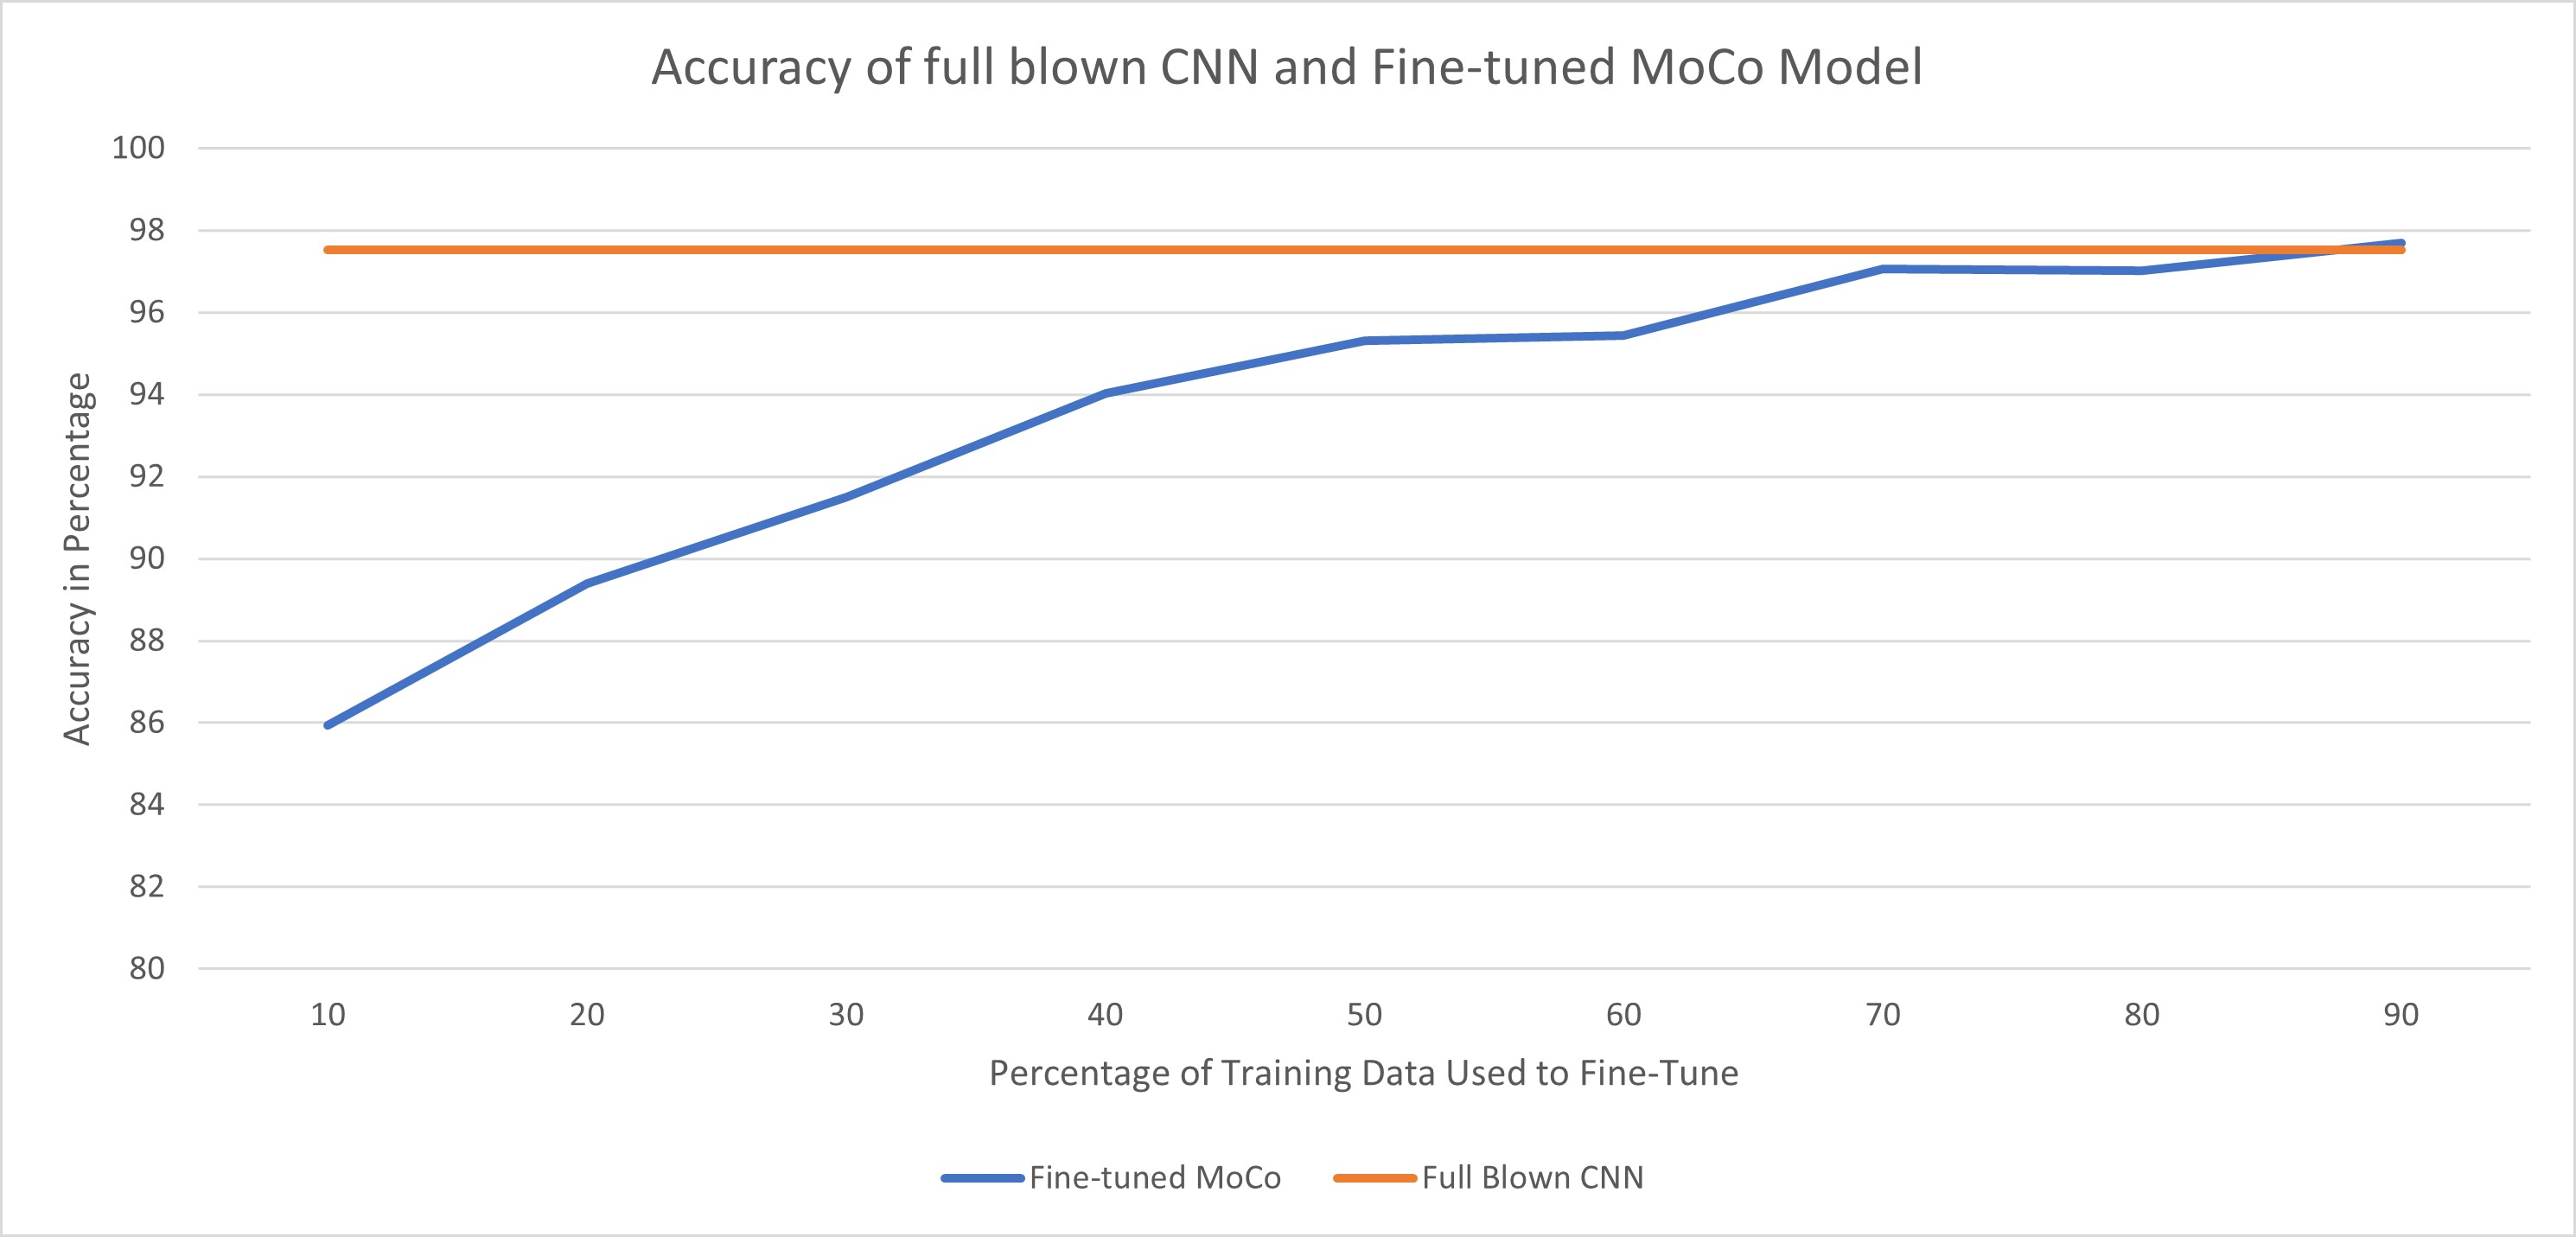

Observations Continued..

3. The red line shows accuracy obtained by full blown CNN
4. From the Chart it can be observed that with around <b>70%</b> of supervised data MoCo model gives competitive
performance to a full blown CNN which is trained on entire training data.
5. With <b>90%</b> Training data it not only equals its performance to CNN model but surpasses it by a slight margin.

# Conclusion
1. With the use of MoCo pretraining we can achieve reduction in the supervised training data needed. and still
achieve performance comparable to the models trained on 100% of data.
2. Particularly in our case we observed comparable performace to a full blown model with <b>30% reduction in supervised data.</b>